In [98]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pickle
from datetime import datetime

import sys
sys.path.insert(0, "..")   
from src.model_utils import train
from src.plot_util import plot_all_sids_losses, plot_loss_per_sid, plot_median_iqr_loss



In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-05-28'

In [73]:
# load
df = pd.read_excel("../output/data/scaled_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
#df = pd.read_excel("../output/data/scaled_train_3_114790_sales_cyclical_features_16_days_X_y.xlsx")
df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_monthofyear_cos_7,y_monthofyear_cos_8,y_monthofyear_cos_9,y_monthofyear_cos_10,y_monthofyear_cos_11,y_monthofyear_cos_12,y_monthofyear_cos_13,y_monthofyear_cos_14,y_monthofyear_cos_15,y_monthofyear_cos_16
0,2013-01-07,3_1047679,3,1047679,0.124703,0.073355,0.085868,0.112190,0.117152,0.196332,...,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013
1,2013-01-08,3_1047679,3,1047679,0.073355,0.085868,0.112190,0.117152,0.196332,0.169148,...,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013
2,2013-01-09,3_1047679,3,1047679,0.085868,0.112190,0.117152,0.196332,0.169148,0.100755,...,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013
3,2013-01-10,3_1047679,3,1047679,0.112190,0.117152,0.196332,0.169148,0.100755,0.099245,...,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013
4,2013-01-11,3_1047679,3,1047679,0.117152,0.196332,0.169148,0.100755,0.099245,0.058684,...,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013,0.933013


In [74]:
df.dtypes

start_date              datetime64[ns]
store_item                      object
store                            int64
item                             int64
sales_day_1                    float64
                             ...      
y_monthofyear_cos_12           float64
y_monthofyear_cos_13           float64
y_monthofyear_cos_14           float64
y_monthofyear_cos_15           float64
y_monthofyear_cos_16           float64
Length: 292, dtype: object

In [75]:
df.columns

Index(['start_date', 'store_item', 'store', 'item', 'sales_day_1',
       'sales_day_2', 'sales_day_3', 'sales_day_4', 'sales_day_5',
       'sales_day_6',
       ...
       'y_monthofyear_cos_7', 'y_monthofyear_cos_8', 'y_monthofyear_cos_9',
       'y_monthofyear_cos_10', 'y_monthofyear_cos_11', 'y_monthofyear_cos_12',
       'y_monthofyear_cos_13', 'y_monthofyear_cos_14', 'y_monthofyear_cos_15',
       'y_monthofyear_cos_16'],
      dtype='object', length=292)

In [76]:
df.shape

(165704, 292)

In [77]:
window_size = 16
cyclical_features = (
  [f"dayofweek_sin_{i}" for i in range(1, window_size+1)]
  + [f"dayofweek_cos_{i}" for i in range(1, window_size+1)]
  + [f"weekofmonth_sin_{i}" for i in range(1, window_size+1)]
  + [f"weekofmonth_cos_{i}" for i in range(1, window_size+1)]
  + [f"monthofyear_sin_{i}" for i in range(1, window_size+1)]
  + [f"monthofyear_cos_{i}" for i in range(1, window_size+1)]
)

sales_features = (
  [f"sales_day_{i}" for i in range(1, window_size+1)]
  + [f"store_med_day_{i}" for i in range(1, window_size+1)]
  + [f"item_med_day_{i}" for i in range(1, window_size+1)]
)
feature_cols = cyclical_features + sales_features
label_cols = [f'y_{c}' for c in feature_cols]

In [78]:
print(len(feature_cols))
print(len(label_cols))


144
144


In [79]:
feature_cols

['dayofweek_sin_1',
 'dayofweek_sin_2',
 'dayofweek_sin_3',
 'dayofweek_sin_4',
 'dayofweek_sin_5',
 'dayofweek_sin_6',
 'dayofweek_sin_7',
 'dayofweek_sin_8',
 'dayofweek_sin_9',
 'dayofweek_sin_10',
 'dayofweek_sin_11',
 'dayofweek_sin_12',
 'dayofweek_sin_13',
 'dayofweek_sin_14',
 'dayofweek_sin_15',
 'dayofweek_sin_16',
 'dayofweek_cos_1',
 'dayofweek_cos_2',
 'dayofweek_cos_3',
 'dayofweek_cos_4',
 'dayofweek_cos_5',
 'dayofweek_cos_6',
 'dayofweek_cos_7',
 'dayofweek_cos_8',
 'dayofweek_cos_9',
 'dayofweek_cos_10',
 'dayofweek_cos_11',
 'dayofweek_cos_12',
 'dayofweek_cos_13',
 'dayofweek_cos_14',
 'dayofweek_cos_15',
 'dayofweek_cos_16',
 'weekofmonth_sin_1',
 'weekofmonth_sin_2',
 'weekofmonth_sin_3',
 'weekofmonth_sin_4',
 'weekofmonth_sin_5',
 'weekofmonth_sin_6',
 'weekofmonth_sin_7',
 'weekofmonth_sin_8',
 'weekofmonth_sin_9',
 'weekofmonth_sin_10',
 'weekofmonth_sin_11',
 'weekofmonth_sin_12',
 'weekofmonth_sin_13',
 'weekofmonth_sin_14',
 'weekofmonth_sin_15',
 'weekofmo

In [80]:
# … shift & drop to build X, y …
# train_df = df.dropna(subset=[f'y_{c}' for c in feature_cols]).reset_index(drop=True)
# train_df.head()

In [81]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [82]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [86]:
# with open('../output/data/3_114790_minmax_X_scaler.pkl', 'rb') as f:
#     X_scaler = pickle.load(f)
with open('../output/data/top10_store_10_item_minmax_y_scaler.pkl', 'rb') as f:
#with open('../output/data/3_114790_minmax_y_scaler.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

In [87]:
hist_df, summary_df, models_dict = train(
    df            = df,
    y_scaler       = y_scaler,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 50,
    seed          = 2025,
    model_dir     = "../output/models/"
)

[3_1047679] Epoch 1/50 train_RMSLE 2.8377, train_MAE 479.2020, test_RMSLE 2.3964, test_MAE 479.8045
[3_1047679] Epoch 2/50 train_RMSLE 2.1965, train_MAE 336.5332, test_RMSLE 1.9553, test_MAE 337.8331
[3_1047679] Epoch 3/50 train_RMSLE 1.7473, train_MAE 207.4732, test_RMSLE 1.5362, test_MAE 209.7409
[3_1047679] Epoch 4/50 train_RMSLE 1.3820, train_MAE 152.5123, test_RMSLE 1.2155, test_MAE 155.5412
[3_1047679] Epoch 5/50 train_RMSLE 1.0790, train_MAE 128.9426, test_RMSLE 0.9651, test_MAE 132.2244
[3_1047679] Epoch 6/50 train_RMSLE 0.8637, train_MAE 115.7136, test_RMSLE 0.8315, test_MAE 118.9390
[3_1047679] Epoch 7/50 train_RMSLE 0.7629, train_MAE 108.8748, test_RMSLE 0.7752, test_MAE 111.9519
[3_1047679] Epoch 8/50 train_RMSLE 0.7222, train_MAE 105.9535, test_RMSLE 0.7495, test_MAE 108.8419
[3_1047679] Epoch 9/50 train_RMSLE 0.7031, train_MAE 104.5931, test_RMSLE 0.7355, test_MAE 107.3345
[3_1047679] Epoch 10/50 train_RMSLE 0.6920, train_MAE 103.7960, test_RMSLE 0.7262, test_MAE 106.4208

In [89]:
hist_df.head(3)


,store_item,epoch,train_loss,train_mae,test_loss,test_mae
0,3_1047679,1,2.837694,479.201976,2.396389,479.804514
1,3_1047679,2,2.196508,336.533199,1.955314,337.833076
2,3_1047679,3,1.747293,207.473200,1.536162,209.740899


In [90]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss
0,3_1047679,0.420064,0.457535
1,3_114790,0.433733,0.454387
2,3_305229,0.415179,0.434107


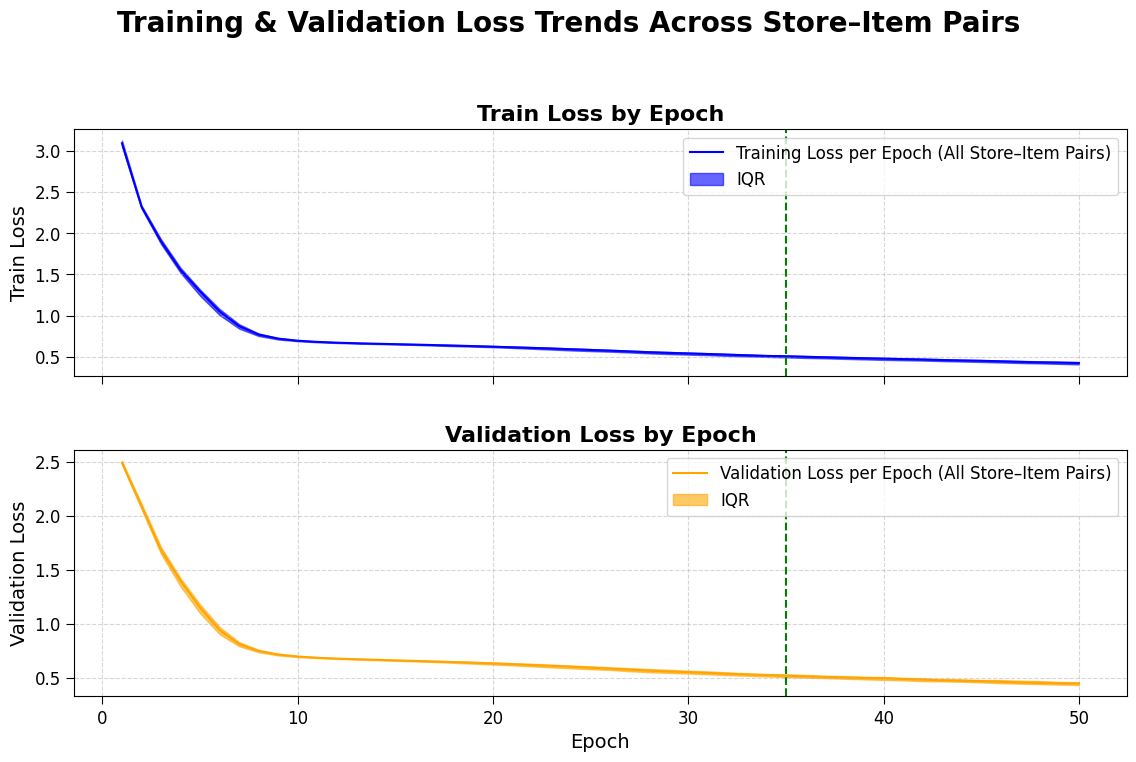

In [100]:
# plot_all_sids_losses(hist_df, 
#                      overall_title="Loss Curves for All Store Items",
# fn=f"../output/figures/all_sids_loss_curves_{today_str}.tiff")
plot_median_iqr_loss(hist_df, 
                     overall_title="Training & Validation Loss Trends Across Store–Item Pairs",
fn=f"../output/figures/median_iqr_loss_curves_{today_str}.tiff")


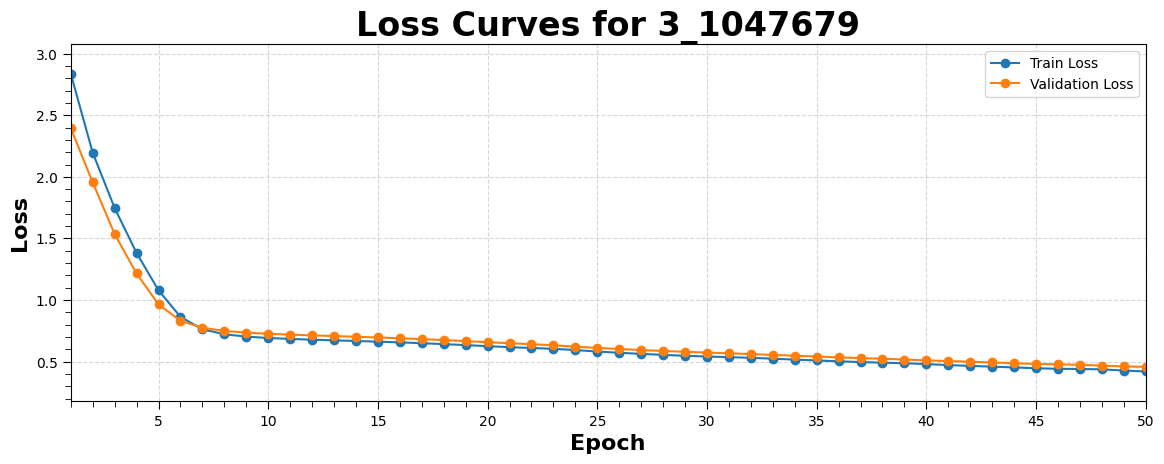

In [94]:
# to plot a single sid:
sid = "3_1047679"
title = f"Loss Curves for {sid}"
plot_loss_per_sid(hist_df, title = title,  sid=sid, fn=f"../output/figures/loss_curves_{sid}_{today_str}.tiff")

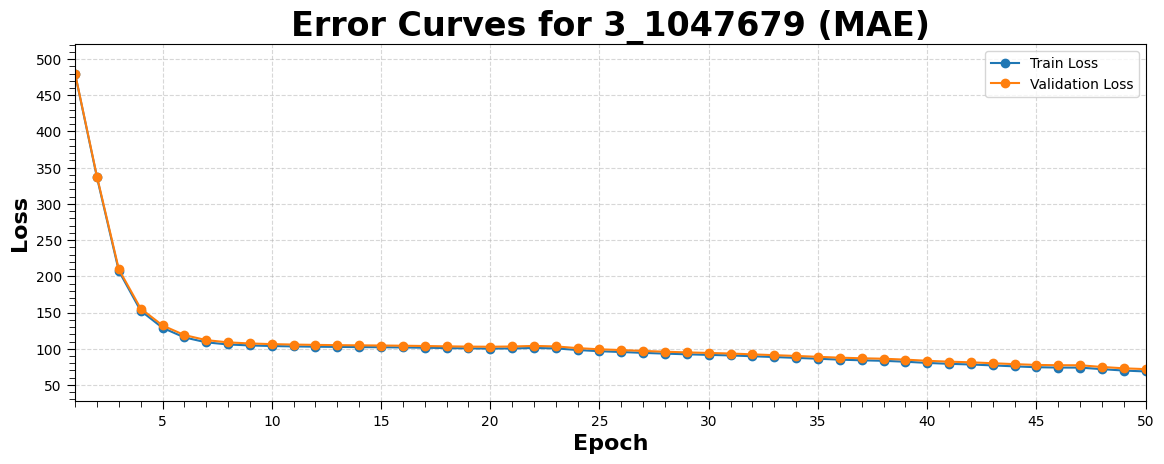

In [95]:
sid = "3_1047679"
title = f"Error Curves for {sid} (MAE)"
plot_loss_per_sid(hist_df, title=title, sid=sid, fn=f"../output/figures/loss_curves_mae_{sid}_{today_str}.tiff", train_col="train_mae", test_col="test_mae")